<a href="https://colab.research.google.com/github/asfawgedamu/Career-Essentials-in-Data-Analysis-by-Microsoft-and-LinkedIn/blob/main/DL_char_ngrams6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 2000})'))
  display(Javascript('google.colab.output.setIframeWidth(0, true, {maxWidth: 2000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [ ]:
import sys
import os
import re
import random
from collections import defaultdict

from nltk import ngrams

from __future__ import print_function
import numpy as np
import pandas as pd
#from keras.utils import np_utils,to_categorical
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV,train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras.models import load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers


from keras.layers.convolutional import Conv1D,MaxPooling1D


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Bidirectional, LSTM



# fix random seed for reproducibility
np.random.seed(7)
random.seed(42)


# Put the hyperparameters at the top like this to make it easier to change and edit.

max_features = 20000
embedding_dim = 64
max_length = 500
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8
num_classes = 3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#pip install graphviz


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import auth,drive
auth.authenticate_user()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
''''#@title
# Libraries for data manipulation and visualization
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))'''






<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'\'#@title\n# Libraries for data manipulation and visualization\nfrom google.colab import files\n\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n  print(\'User uploaded file "{name}" with length {length} bytes\'.format(\n      name=fn, length=len(uploaded[fn])))'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Start by connecting gdrive into the google colab

import os
os.chdir ("/content/gdrive/MyDrive/")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls -l /content/gdrive/MyDrive/ |head


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ls: /content/gdrive/MyDrive/Thesis: No such file or directory
total 660701
-rw------- 1 root root        63 Dec 23  2017 0966960495.vcf
-rw------- 2 root root    238450 Jan 20  2019 165510-426981-1-SM.pdf
-rw------- 1 root root   1205760 Sep  1  2019 1_IR_intro.ppt
-rw------- 1 root root   1345536 Sep  1  2019 2_text operation.ppt
-rw------- 1 root root   1504256 Sep  1  2019 3_termWeighting.ppt
-rw------- 1 root root   3445071 Apr 17 18:14 4_5976689323028776928.pdf
-rw------- 1 root root   1160192 Sep  1  2019 4_ Indexing.ppt
-rw------- 1 root root   1425920 Sep  1  2019 5_IRModels.ppt
-rw------- 1 root root   1172992 Sep  1  2019 6_Retrieval Evaluation.ppt


In [ ]:
!cd ColabNotebooks

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls ColabNotebooks
!pwd

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 all_source111.tsv     'Multi-Class Text Classification with LSTM TDI  .ipynb'
 DL-char-ngrams.ipynb  'Text Classification with LSTM TDI .ipynb'
/content/gdrive/MyDrive


In [ ]:
!pwd

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/content/gdrive/MyDrive


In [ ]:
#Text Preprocessing step
#Remove alphanumeric characters, punctuation marks and symbols

BLOCK_CHAR = """'()[]":፣፡፡፡“”።?::፥፤]+\*_-‘’!""" + 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
BLOCK_CHAR = ''.join(BLOCK_CHAR.split())

def clean_text(raw_text):
    #raw_text = re.sub(r"()["":፣ ፡፡''፡“ ” ።?::፥፤]+\ *", " ", raw_text)
    for c in BLOCK_CHAR:
        if c not in raw_text:
            continue
        raw_text = raw_text.replace(c, '')
    return raw_text

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def load_data(fin):
    '''accepts fin a string representing file name
    returns list of lines in a file'''
    X = []
    y = []
    with open(fin, encoding="utf8") as f:
        labels = next(f).rstrip('\n').split('\t')
        for line in f:
            parts = line.rstrip('\n').split('\t')
            if len(set(parts)) != 3:
                continue
            for part, label in zip(parts, labels):

                part = clean_text(part)
                if part.strip() == '':
                    continue
                X.append(part)
                y.append(label)
    return X,y

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X,y = load_data('/content/gdrive/MyDrive/ColabNotebooks/all_source111.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def gen_ngrams(s, ns=(1,2,3)):
    '''takes s string and ns tuple as arguments
    generates ngram strings'''
    for n in ns:
        for ngram in ngrams(s,n):
            ngram = ''.join(ngram)
            yield ngram

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def ngram_freq(sents, ns=(1,2,3)):
    ngram_tokens = defaultdict(int)
    for s in sents:
        for ngram in gen_ngrams(s, ns):
            ngram_tokens[ngram] += 1
    return ngram_tokens

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# generating ngrams with values 1, 2 and 3
ngram_tokens = ngram_freq(X, ns=(1,))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# sorts ngrams by frequency from most frequent to least frequent
top_ngrams_freq = sorted(ngram_tokens.items(), key=lambda x:x[1], reverse=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
word_list =  [oov_tok] + [i[0] for i in top_ngrams_freq[:max_features]]
word_index = dict([(j,i) for (i,j) in enumerate(word_list, start=1)])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dict(list(word_index.items())[0:10])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{' ': 2,
 '<OOV>': 1,
 'ል': 8,
 'ም': 5,
 'ር': 9,
 'ብ': 4,
 'ት': 6,
 'ን': 7,
 'ኣ': 10,
 'ይ': 3}

In [ ]:
#Display sample sentences
X[0]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'ወዲ ሰብ ካብ ፍጥረታት ዓለምና ዅሉ በዓል ብሩህ ኣእምሮ መስተውዓሊ ብልሂ ብምዃኑ ዘጋጥምዎ ፀገማት ፈተናታት ከባቢኡ ናብ ረብሕኡ ንምልዋጥ ብዙሓት መፍትሒ ምህዞታት ሜላታት ፈጢሩ'

In [ ]:
# Note: the ngram sequence (ns) we use for feature generation
#must match the one used to build the dictionary
#[i for i in gen_ngrams(X[0], ns=(1,))]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Sample text to confirm if the codes above are working

a = 'እቲ ናይትግራይ ቴሌቪዥን ጋዜጠኛ ዮውሃንስ ዝበሃል ግን ጋዜጠኛዶ ወይስ ወኪል ህወሓት ይግርም'
t = [i for i in gen_ngrams(a, ns=(1,))]
idx = [word_index.get(tok, 1) for tok in t]
#print(t)
print(t + idx)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

['እ', 'ቲ', ' ', 'ና', 'ይ', 'ት', 'ግ', 'ራ', 'ይ', ' ', 'ቴ', 'ሌ', 'ቪ', 'ዥ', 'ን', ' ', 'ጋ', 'ዜ', 'ጠ', 'ኛ', ' ', 'ዮ', 'ው', 'ሃ', 'ን', 'ስ', ' ', 'ዝ', 'በ', 'ሃ', 'ል', ' ', 'ግ', 'ን', ' ', 'ጋ', 'ዜ', 'ጠ', 'ኛ', 'ዶ', ' ', 'ወ', 'ይ', 'ስ', ' ', 'ወ', 'ኪ', 'ል', ' ', 'ህ', 'ወ', 'ሓ', 'ት', ' ', 'ይ', 'ግ', 'ር', 'ም', 11, 39, 2, 15, 3, 6, 22, 38, 3, 2, 164, 151, 193, 209, 7, 2, 73, 122, 74, 136, 2, 80, 36, 42, 7, 13, 2, 33, 19, 42, 8, 2, 22, 7, 2, 73, 122, 74, 136, 104, 2, 34, 3, 13, 2, 34, 131, 8, 2, 45, 34, 21, 6, 2, 3, 22, 9, 5]


In [ ]:
def tokenizer(X, ns=(1,2)):
    """using list comprehension
    X_tok = [i for i in gen_ngrams(x, ns=(1,2,3)) for x in X]
    """
    tokenized = []
    for x in X:
        toks = [tok for tok in gen_ngrams(x, ns)]
        idx = [word_index.get(tok, 1) for tok in toks]
        tokenized.append(idx)
        if max(idx) > 20000 + 1:
            print(x)
    return tokenized

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_tok = tokenizer(X)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_tok[1][:5]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[34, 59, 2, 30, 4]

In [ ]:
word_index['ብ']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4

In [ ]:
# maximum length of tokens in our dataset
max([len(X_tok[i]) for i in range(len(X_tok))])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

503

In [ ]:
# Which sentences is this?
# TODO: Should we sort features?
for idx, i in enumerate(range(len(X_tok))):
    if len(X_tok[i]) == 503:
        print(idx)
        print(X[idx])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

12
ህዝብታት ዓለም ዝሓለፉዎ ታሪክ ጐንፅታት ሕድሕድ ኣብ ኣህጉርና ኣብ ሃገርና ኢትዮጵያ ኰነ ኣብ ትግራይ ብዓሌት ብዘርኢ ብከባቢ ብብሄር ሓው ምስ ሓው ባእሲ ብነብሲ ምድልላይ ኣተሓሳስባ ድሕረት ጐዳእቲ ባህላዊ ፍፃመታት ካብ ዝበሃሉ ሰብ ንሰብ ብምስዓሩ ብምጕድኡ ወይከዓ ብምቕታሉ መላሲ ደም ፈዳይ ሕነ እናተብሃለ ከም ፍሉይ መለክዒ ጅግንነት ተገይሩ እናተቘፀረሉ ዝነበረ ዘመናት ተዘክሮ ቀረባ እዋን እዩ


In [ ]:
# Pads a single character

def pad_seq(l, max_length):
    if len(l) == max_length:
        return l
    elif len(l) < max_length:
        return l + [1]*(max_length - len(l))
    else:
        return l[:max_length]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Pads all input sequences

def pad_seqs(X, max_length):
    res = []
    for x in X:
        l = np.array(pad_seq(x, max_length))
        res.append(l)
    return np.array(res)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# check
#X_tok_padded = pad_sequences(X_tok, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_tok_padded = pad_seqs(X_tok, max_length=max_length)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#our labels are in Z, L, D but we want a three dimensional vector corresponding to each class
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_ = lb.fit_transform(y)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(y[:5])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

['Z', 'L', 'D', 'Z', 'L']


In [ ]:
print(y_[:5])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tok_padded, y_, test_size=0.2, random_state=42)

print(len(X))
print(len(y))

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

print('Train shape:',X_train.shape)
print('Test shape:',X_test.shape)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

7971
7971
6376 6376
1595 1595
Train shape: (6376, 500)
Test shape: (1595, 500)


In [ ]:
len(tokenizer([X[0]])[0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

223

In [ ]:
X_train[0][:100]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([  4,  21,  23,   2,  74,  71,   9,  58,   2,  11,   7,   6,  27,
        79,   2,  11,   7,  23,   9,  25,   2,  11,   7,  51,   9,   6,
        28,   2,   6,   9,  94, 106,   2,  26,  59,   2,   9,   6,  28,
         3,   2,  31,   6,  20,   3,   2,  26,  59,   2,   4,   8,  21,
         6,   3,   2,   4,  13,  12,   6,   3,   2,  26,  59,   2,  31,
         8,  74,   6,   2,  26,  59,   2,  51,  23,   2,  26,  59,   2,
       117,  73,  77,   2,  26,  59,   2,  21,  84,   2,  26,  59,   2,
        11,   5,  17,   6,   7,   2,  46,   7,  26])

# BI-LSTM Reference

François Chollet.(2020/05/03). Bidirectional LSTM on IMDB. Retrieved 30 August 2021, from: https://keras.io/examples/nlp/bidirectional_lstm_imdb/

In [ ]:
# create a Bi-LSTM model
from tensorflow.keras import regularizers
def BiLSTM_model(drop_out,filter_one,recurrent_dropout,filter_two, batch_size,learning_rate,last_dense, padding, num_epochs):
    model = tf.keras.Sequential([
        # Add an Embedding layer expecting input vocab of size 20000,
        # and output embedding dimension of size 64 we set at the top
        tf.keras.layers.Embedding(max_features+2,embedding_dim,input_shape=(max_length,)),
        #To add Bidirectional layers sequencially, use return_sequences=True

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(filter_one,return_sequences=True)),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(filter_one,return_sequences=True)),
        tf.keras.layers.Dropout(drop_out),

        # use ReLU in place of tanh function since they are very good alternatives of each other.
        #tf.keras.layers.Dense(last_dense, activation='relu'), #Check with and without this layer

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(filter_two)),
        tf.keras.layers.Dropout(drop_out),


        tf.keras.layers.Dense(last_dense, activation='relu',kernel_regularizer=regularizers.l1(0.01)),
        #tf.keras.layers.MaxPool1D(),
        # Add a Dense layer with 3 units and softmax activation.
        # We have three outputs, softmax converts output layers into a probability distribution.
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.summary()

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #Drow the BiLSTM Neural Network architecture

    plot_model(model, to_file='./BiLSTM_model_plot.png', show_shapes=True, show_layer_names=True)


    # simple early stopping

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

    # Add Checkpointing

    checkpointer = ModelCheckpoint(filepath='./best_BiLSTM_checkpoint.hdf5',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   monitor='val_accuracy',
                                   mode='max',
                                   save_freq="epoch")
    # Model weights are saved at the end of every epoch, if it's the best seen so far
    history = model.fit(X_train, y_train, epochs=num_epochs,validation_data=(X_test, y_test), verbose=2,callbacks=[checkpointer])

    # Evaluate the model on the test data (this is for testing time, with the testing dataset)
    # Returns the loss value & metrics values for the model in test mode.

    print('\n')
    print("Evaluate on test data",'\n')
    results = model.evaluate(X_test, y_test, batch_size=64)
    print("Test Loss:",results[0])
    print("Test Accuracy:",results[1])

    # Generate output predictions for the input samples(probabilities -the output of the last layer) on new data
    # (this is for somewhere between training and testing time).
    # Use this model to do some feed-forward passes to predict novel inputs.

    print('\n')
    #assert np.allclose(model.predict(X_test), loaded_model.predict(X_test))
    predictions = model.predict(X_test)
    print("predictions shape:", predictions.shape)
    y_pred = (predictions)

    #Creating a confusion matrix,which compares the y_test and y_pred
    #Note The support column in classification_report is:
    #the number of occurrences of each class in y_test.It shows testset distribution
    # Plotting training and validation loss graph

    results = pd.DataFrame(
    confusion_matrix( y_test.argmax(axis=1), y_pred.argmax(axis=1)),
    index=['D', 'L', 'Z'],
    columns=['D', 'L', 'Z'])

    print('-'*80,'\n')
    print('Confusion Matrix of BiLSTM Model', '\n')
    print(results,'\n')

    print('Classification Report : ','\n')
    target_names = ['D-variety', 'L-variety', 'Z-variety']
    print (classification_report(y_test.argmax(axis=1),y_pred.argmax(axis=1),target_names=target_names),'\n')

   # Plotting training and validation loss graph
    print("Plotting Loss and Accuracy Graphs",'\n')
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

    # Plotting training and validation Accuracy graph
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

    return history.history

In [ ]:
max_features = max_features
embedding_dim = 64
BiLSTM_model(drop_out=0.6,recurrent_dropout=0.4,filter_one=64, filter_two=64, batch_size=1024,learning_rate=1e-1,last_dense=64, padding="same",num_epochs=60)

NameError: ignored

# CNN  Model Reference

Mark Omernick, Francois Chollet. (2019). Text classification from scratch. Retrieved on 30 August 2021, from: https://keras.io/examples/nlp/text_classification_from_scratch/

In [ ]:
#Create CNN Function to use the keras model in the scikit-learn wrapping class KerasClassifier
#To use this wrapper we must define a function that creates and returns your Keras sequential model,

from sklearn.model_selection import RandomizedSearchCV
from keras.utils.vis_utils import plot_model
def cnn_model(drop_out, filter_one,last_dense, learning_rate,padding,num_epochs):
    # create a CNN model
    model = tf.keras.Sequential([
        # Add an Embedding layer expecting input vocab of size 20000, and output embedding dimension of size 64 we set at the top
        tf.keras.layers.Embedding(max_features+2,embedding_dim,input_shape=(500,)),

        # use ReLU in place of tanh function since they are very good alternatives of each other
        tf.keras.layers.Conv1D(filters=128, kernel_size=3,padding=padding,activation='relu'),
        tf.keras.layers.Dropout(drop_out),

        # Conv1D + global max pooling
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,padding=padding,activation='relu'),
        tf.keras.layers.GlobalMaxPool1D(),
        tf.keras.layers.Dropout(drop_out),


        # Add a vanilla hidden layer
        tf.keras.layers.Dense(last_dense,activation='relu',kernel_regularizer=regularizers.l2(0.01)),

        # Add a Dense layer with 3 units since the output should be three(no. Classes)
        # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    #model.get_weights()
    #model.count_params()
    model.summary()

    # Decide a model architecture, this is the number of hidden layers and activation functions, etc.

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    plot_model(model, to_file='./CNN_model_plot.png', show_shapes=True, show_layer_names=True)

    # Train the model for a given number of epochs(this is for training time, with the training dataset).
    # Train our model to get all the paramters to the correct value to map our inputs to our outputs.

    # simple early stopping

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

    #an epoch is one learning cycle where the learner sees the whole training data set.
    checkpointer = ModelCheckpoint(filepath='./best_CNN_checkpoint.hdf5',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   monitor='val_accuracy',
                                   mode='max',
                                   save_freq="epoch")

    history = model.fit(X_train, y_train, epochs=num_epochs,validation_data=(X_test, y_test), verbose=2,callbacks=[checkpointer,es])

    # Evaluate the model on the test data (this is for testing time, with the testing dataset)
    # Returns the loss value & metrics values for the model in test mode.
    # we can’t pass the entire dataset into the neural net at once.
    # So, we divide the dataset into Number of Batches or sets or parts.
    print('\n')
    print("Evaluate on test data",'\n')
    results = model.evaluate(X_test, y_test, batch_size=64)
    print("Test Loss:",results[0])
    print("Test Accuracy:",results[1])

    # Generate output predictions for the input samples(probabilities -the output of the last layer) on new data
    # (this is for somewhere between training and testing time).
    # Use this model to do some feed-forward passes to predict novel inputs.

    print('\n')
    predictions = model.predict(X_test)
    print("predictions shape:", predictions.shape)
    y_pred = (predictions)

    #Creating a confusion matrix,which compares the y_test and y_pred
    #Note The support column in classification_report is:
    #the number of occurrences of each class in y_test.It shows testset distribution
    # Plotting training and validation loss graph

    results = pd.DataFrame(
    confusion_matrix( y_test.argmax(axis=1), y_pred.argmax(axis=1)),
    index=['D', 'L', 'Z'],
    columns=['D', 'L', 'Z'])

    print('-'*80,'\n')
    print('Confusion Matrix of CNN Model', '\n')
    print(results,'\n')

    print('Classification Report : ','\n')
    target_names = ['D-variety', 'L-variety', 'Z-variety']
    print (classification_report(y_test.argmax(axis=1),y_pred.argmax(axis=1),target_names=target_names),'\n')

   # Plotting training and validation loss graph
    print("Plotting Loss and Accuracy Graphs",'\n')
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

    # Plotting training and validation Accuracy graph
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

    return history.history

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 64)           1280128   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 128)          24704     
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 64)           24640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

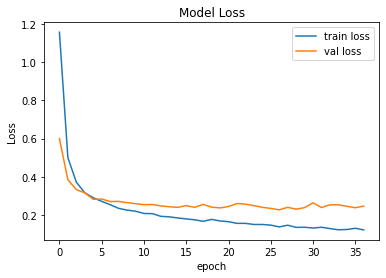

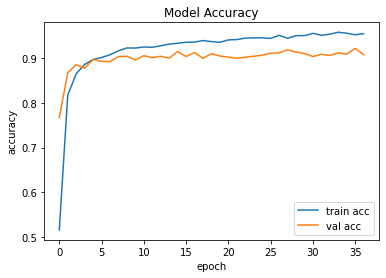

{'accuracy': [0.5163111686706543,
  0.816656231880188,
  0.8644918203353882,
  0.8851944804191589,
  0.8963299989700317,
  0.9007214307785034,
  0.9068381190299988,
  0.9156211018562317,
  0.9220514297485352,
  0.921737790107727,
  0.9240903258323669,
  0.923462986946106,
  0.9269134402275085,
  0.9305207133293152,
  0.932559609413147,
  0.9347553253173828,
  0.9350690245628357,
  0.9385194182395935,
  0.9361668825149536,
  0.9345985054969788,
  0.9399309754371643,
  0.9407151937484741,
  0.9438519477844238,
  0.9444792866706848,
  0.9446361064910889,
  0.9432246088981628,
  0.9501254558563232,
  0.943538248538971,
  0.9494981169700623,
  0.9494981169700623,
  0.9545169472694397,
  0.9502823352813721,
  0.952634871006012,
  0.9570263624191284,
  0.9548305869102478,
  0.95138019323349,
  0.9538896083831787],
 'loss': [1.15540611743927,
  0.5010048747062683,
  0.37277817726135254,
  0.31729498505592346,
  0.2914511561393738,
  0.2726144790649414,
  0.2553664445877075,
  0.236033305525779

In [ ]:
max_features = max_features
embedding_dim = 64
cnn_model(drop_out=0.4, filter_one=64, filter_two=128,last_dense=64, padding='same',learning_rate=1e-4, num_epochs=60)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 64)           1280128   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 500, 128)          24704     
_________________________________________________________________
dropout_4 (Dropout)          (None, 500, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 500, 64)           24640     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

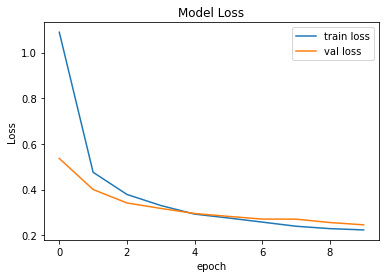

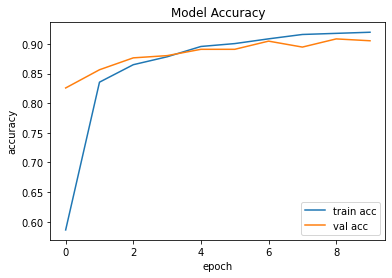

In [ ]:
# Create KerasClassifier model
# Then pass the cnn_model function to the build_fn argument when constructing the KerasClassifier class.


max_features = max_features
embedding_dim = 64
model = cnn_model(drop_out=0.4, filter_one=64,last_dense=64, padding='same',learning_rate=1e-4, num_epochs=10)


In [ ]:
estimator = KerasClassifier(build_fn=cnn_model, epochs=10, batch_size=32, verbose=2)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 199.0min finished


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 64)           1280128   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 498, 128)          24704     
_________________________________________________________________
dropout_6 (Dropout)          (None, 498, 128)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 496, 64)           24640     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

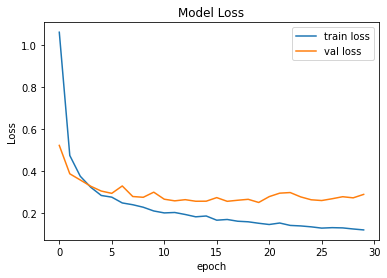

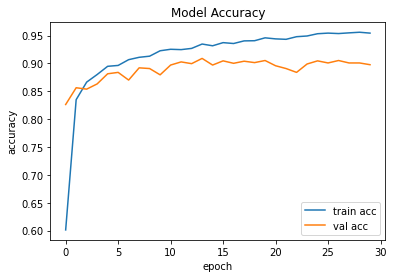

AttributeError: ignored

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV



cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=3, random_state=1)
# define search space

space = {
    'filter_one':[32,64,128],
    'num_epochs': [20,40,60],
    'last_dense':[32,64,128],
    'batch_size':[64,128,256],
    'learning_rate':[0.001,0.0001,0.00001],
    'drop_out':[0.3,0.4,0.5],
    'padding': ['same','valid']

}

search = RandomizedSearchCV(estimator=estimator,
                    n_jobs=-1,
                    verbose=2,
                    return_train_score=True,
                    n_iter=3,
                    scoring='accuracy',
                    cv=5,
                    param_distributions=space,
                    random_state=1)
# define search
#search = RandomizedSearchCV(estimator, param_grid, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
# Define the most relevant grid search parameters
# A dictionary of hyperparameters to evaluate in the param_grid argument.
# This is a map of the model parameter name and an array of values to try.

param_grid = {
    'filter_one':[32,64,128],
    'num_epochs': [20,40,60],
    'last_dense':[32,64,128],
    'batch_size':[64,128,256],
    'learning_rate':[0.001,0.0001,0.00001],
    'drop_out':[0.3,0.4,0.5],
    'padding':['same','valid']
}


# Create KerasClassifier model
# Then pass the cnn_model function to the build_fn argument when constructing the KerasClassifier class.

estimator = KerasClassifier(build_fn=cnn_model, epochs=10, batch_size=32, verbose=2)


The batch size in iterative gradient descent is the number of patterns shown to the network before the weights are updated.
It is also an optimization in the training of the network, defining how many patterns to read at a time and keep in memory.

The number of epochs is the number of times that the entire training dataset is shown to the network during training.
Some networks are sensitive to the batch size, such as LSTM, RNN and CNN.

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
    
    
We would like to fine-tune these hyperparameters: fileters, dropout_rate,number of epochs,batch_size,padding and dense_layer_size.

These parameters must be defined in the signature of cnn_model() function with default parameters.

https://medium.com/@am.benatmane/keras-hyperparameter-tuning-using-sklearn-pipelines-grid-search-with-cross-validation-ccfc74b0ce9f

In [ ]:
# Define the most relevant grid search parameters
# A dictionary of hyperparameters to evaluate in the param_grid argument.
# This is a map of the model parameter name and an array of values to try.

param_grid = {
    'filter_one':[32,64,128],
    'num_epochs': [20,40,60],
    'last_dense':[32,64,128],
    'batch_size':[32,64,128,256],
    'learning_rate':[0.001,0.0001,0.00001],
    'drop_out':[0.2,0.3,0.4,0.5],
    'padding':['same','valid']
}


1. estimator : Pass the model instance for which you want to check the hyperparameters.
2.params_grid: the dictionary object that holds the hyperparameters you want to try
3.scoring: evaluation metric that you want to use, you can simply pass a valid string/ object of evaluation metric
4.cv: number of cross-validation you have to try for each selected set of hyperparameters
5.verbose: you can set it to 1 to get the detailed print out while you fit the data to GridSearchCV
6.n_jobs: number of processes you wish to run in parallel for this task if it -1 it will use all available processors.
    
https://www.mygreatlearning.com/blog/gridsearchcv/

In [ ]:
# Conduct grid search with Kfold cross validation
# We use Kfold cross validation to check how well our model is able to generalize the unseen data
#Grid search is a model hyperparameter optimization technique.
# By default, accuracy is the score that is optimized,
# but other scores can be specified in the score argument of the GridSearchCV constructor.
#By default, the grid search will only use one thread.
# By setting the n_jobs argument in the GridSearchCV constructor to -1, the process will use all core processors on your machine.
# Depending on your Keras backend, this may interfere with the main neural network training process.

grid = GridSearchCV(estimator=estimator,
                    n_jobs=-1,
                    verbose=2,
                    return_train_score=True,
                    scoring=['accuracy','precision_macro','recall_macro'],
                    refit='precision_macro',
                    cv=3,
                    param_grid=param_grid)

In [ ]:
#  access the outcome of the grid search in the result object returned from grid.fit().

grid_result = grid.fit(X_train, y_train, verbose=2)

# summarize results
# The best_score_ member provides access to the best score observed during the optimization procedure
# and the best_params_ describes the combination of parameters that achieved the best results


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 2592 candidates, totalling 7776 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


sklearn.model_selection.GridSearchCV
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
def run_experiments():
    # grid search
    drop_outs = (0.3,0.4,0.5,0.6, 0.7)
    filters_one = (32, 64, 128,256)
    filters_two = (32, 64, 128,256)
    last_dense_layers = (32, 64, 128,256)
    paddings = ('same', 'valid')

    results = []
    for drop_out in drop_outs:
        for filter_one in filters_one[:-1]:
            for filter_two in filters_two:
                for last_dense in last_dense_layers:
                    for padding in paddings:
                        res = cnn_bilstm_model(drop_out, filter_one, filter_two, last_dense, padding,num_epochs=50)
                        #res = 'running ...'
                        results.append({'drop_out': drop_out,
                                   'filter_one': filter_one,
                                   'filter_two': filter_two,
                                    'last_dense': last_dense,
                                    'padding': padding,
                                    'history': res})
    return results

In [ ]:
#r = run_experiments()

In [ ]:
# Combination of CNN and BI-LSTM models

def cnn_bilstm_model(drop_out, filter_one, filter_two,learning_rate, last_dense, padding, num_epochs):
    # create a CNN model
    model = tf.keras.Sequential([
        # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
        tf.keras.layers.Embedding(max_features+2,embedding_dim,input_shape=(500,)),

        # use ReLU in place of tanh function since they are very good alternatives of each other

        tf.keras.layers.Conv1D(filters=filter_one, kernel_size=3, padding=padding, activation='relu'),
        tf.keras.layers.MaxPool1D(pool_size=4),

        # During the training of our model, we randomly cause some of the neurons to be excluded
        # from the neural network (i.e. drop out) at each step with a fixed probability.
        tf.keras.layers.Dropout(drop_out),


        tf.keras.layers.Conv1D(filters=filter_two, kernel_size=3, padding=padding, activation='relu'),
        tf.keras.layers.MaxPool1D(pool_size=4),
        tf.keras.layers.Dropout(drop_out),


        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dropout(drop_out),
        tf.keras.layers.Dense(last_dense, activation='relu',kernel_regularizer=regularizers.l2(0.01)), #check with and without this layer

        # Add a Dense layer with 3 units and softmax activation.
        # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.summary()

    # Decide a model architecture, this is the number of hidden layers and activation functions, etc.

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    plot_model(model, to_file='./CNN-BiLSTM_model_plot.png', show_shapes=True, show_layer_names=True)


    #history = model.fit(X_train, y_train, epochs=num_epochs,validation_data=(X_test, y_test),callbacks=[es], verbose=0)


    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

    # The ModelCheckpoint callback class allows you to define where to checkpoint the model weights,
    # how the file should named and under what circumstances to make a checkpoint of the model.

    checkpointer = ModelCheckpoint(filepath='./best_CNN-BiLSTM_checkpoint.hdf5',
                                   monitor='val_accuracy', verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='max',
                                   save_freq="epoch")

    # Train the model for a given number of epochs(this is for training time, with the training dataset).
    # Train our model to get all the paramters to the correct value to map our inputs to our outputs.
    # The model is evaluated on the validation dataset at the end of each training epoch.
    # The function is called ‘fit’ as we are fitting the parameters to the data.
    history = model.fit(X_train, y_train, epochs=num_epochs,validation_data=(X_test, y_test), verbose=2,callbacks=[checkpointer])


    # Evaluate the model on the test data (this is for testing time, with the testing dataset)
    # Returns the loss value & metrics values for the model in test mode.

    print('\n')
    print("Evaluate on test data",'\n')
    test_results = model.evaluate(X_test, y_test,batch_size=64)
    print("Test Loss:",test_results[0])
    print("Test Accuracy:",test_results[1])

    # evaluate the model
    #_, train_acc = model.evaluate(X_train, y_train, verbose=0)
    #_, test_acc =  model.evaluate(X_test, y_test, verbose=0)
    #print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    # Generate output predictions for the input samples(probabilities -the output of the last layer) on new data
    # (this is for somewhere between training and testing time).
    # Use this model to do some feed-forward passes to predict novel inputs.

    print('\n')
    predictions = model.predict(X_test)
    print("predictions shape:", predictions.shape)
    y_pred = (predictions)

    #Creating a confusion matrix,which compares the y_test and y_pred
    #Note The support column in classification_report is:
    #the number of occurrences of each class in y_test.It shows testset distribution
    # Plotting training and validation loss graph

    results = pd.DataFrame(
    confusion_matrix( y_test.argmax(axis=1), y_pred.argmax(axis=1)),
    index=['D', 'L', 'Z'],
    columns=['D', 'L', 'Z'])

    print('-'*80,'\n')
    print('Confusion Matrix of Hybrid CNN and Bi-LSTM Model', '\n')
    print(results,'\n')

    print('Classification Report : ','\n')
    target_names = ['D-variety', 'L-variety', 'Z-variety']
    print (classification_report(y_test.argmax(axis=1),y_pred.argmax(axis=1),target_names=target_names),'\n')


    # Plotting training and validation loss graph
    print("Training and Validation Loss Graph")
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

    # Plotting training and validation Accuracy graph
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

    return history.history

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 64)           1280128   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 500, 128)          24704     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 125, 128)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 125, 128)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 125, 64)           24640     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 31, 64)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 31, 64)           

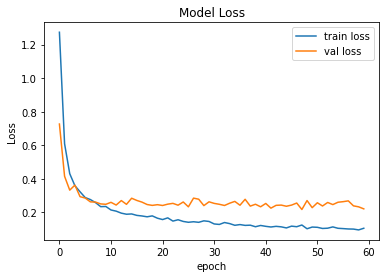

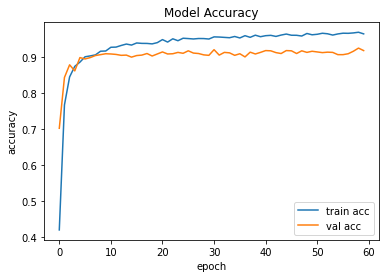

{'accuracy': [0.4193851947784424,
  0.7663111686706543,
  0.8441028594970703,
  0.8734316229820251,
  0.8851944804191589,
  0.9000940918922424,
  0.9024466872215271,
  0.9052697420120239,
  0.9154642224311829,
  0.9160916209220886,
  0.9264429211616516,
  0.9269134402275085,
  0.931461751461029,
  0.9353826642036438,
  0.932559609413147,
  0.9383625984191895,
  0.9372647404670715,
  0.9371079206466675,
  0.9358531832695007,
  0.9393036365509033,
  0.9477729201316833,
  0.9408720135688782,
  0.9499686360359192,
  0.9446361064910889,
  0.951537013053894,
  0.9505959749221802,
  0.9494981169700623,
  0.9507527947425842,
  0.9505959749221802,
  0.9493412971496582,
  0.9553011059761047,
  0.9548305869102478,
  0.9538896083831787,
  0.9529485702514648,
  0.9563990235328674,
  0.9523212313652039,
  0.9585947394371033,
  0.9540464282035828,
  0.9600062966346741,
  0.9557716250419617,
  0.9585947394371033,
  0.9595357775688171,
  0.9565558433532715,
  0.9603199362754822,
  0.9631430506706238,
 

In [ ]:

max_features = max_features
embedding_dim = 64
cnn_bilstm_model(drop_out=0.5, filter_one=128, filter_two=64,learning_rate=1e-5,last_dense=64, padding='same', num_epochs=60)

In [ ]:
os.chdir('/content/gdrive/MyDrive/ColabNotebooks/')

In [ ]:
!ls /content/gdrive/MyDrive/ColabNotebooks/

 all_source111.tsv     'Multi-Class Text Classification with LSTM TDI  .ipynb'
 DL-char-ngrams.ipynb  'Text Classification with LSTM TDI .ipynb'
